In [2]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

%matplotlib inline
from nuscenes.nuscenes import NuScenes
from util.depth_map_utils import *
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import util.opt as opt
import os
import cv2
from pyquaternion import Quaternion
from util.inverse_warp import *
from util.image import *
from util.io import *
from util.data import *

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from network.net import PConvUNet, VGG16FeatureExtractor, NLayerDiscriminator

In [3]:
batch_size = 1
n_threads = 4

# dataset = NusceneDataset('../../nuscene/dataset_orig/', train=False, random_mask=True)
dataset = NusceneDataset('../dataset/', train=True, random_mask=False)
iterator = iter(data.DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=InfiniteSampler(len(dataset)),
    num_workers=n_threads
))

# load model GAN
modelG0 = PConvUNet()
modelG0.eval()
start_iter = load_ckpt(
    "../snapshots_GAN/ckpt_GAN_beta_10.00/1000000.pth", [('model', modelG0)],
    None
)

# # load model GAN
# modelG1 = PConvUNet()
# modelG1.eval()
# start_iter = load_ckpt(
#     "../snapshots_GAN/beta_100.00/1000000.pth", [('model', modelG1)],
#     None
# )

# # load model GAN
# modelG2 = PConvUNet()
# modelG2.eval()
# start_iter = load_ckpt(
#     "../snapshots_GAN/alpha_0.75/1000000.pth", [('model', modelG2)],
#     None
# )

# load vanilla model
modelV = PConvUNet()
start_iter = load_ckpt(
    "../snapshots_GAN/ckpt_GAN_alpha_1.00/1000000.pth", [('model', modelV)],
    None
)
modelV.eval()

# models = [modelV, modelG0, modelG1, modelG2]
models = [modelV, modelG0]

In [4]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(60, 7.5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

In [5]:
def test():
    tx = 0.0 * 2 * (np.random.rand(batch_size) - 0.5)
    ry = 0.3 * 2 * (np.random.rand(batch_size) - 0.5)
    tx = np.sign(tx).item() * torch.tensor(np.clip(tx, 0.75, 1.50))
    ry = np.sign(ry).item() * torch.tensor(np.clip(ry, 0.15, 0.20))
    
    # extract sample
    while True:
        sample = next(iterator)
        gt, img, depth = sample['gt'], sample['img'], sample['depth']
        intrinsic, extrinsic = sample['intrinsic'], sample['extrinsic']
        
        if (depth > 0).sum().float() / (depth.shape[1] * depth.shape[2]) >= 0.7:
            break
        
    # convert to doubles
    depth = depth.double()
    intrinsic = intrinsic.double()
    extrinsic = extrinsic.double()

    # add pose
    pose = torch.zeros((batch_size, 6)).double()
    pose[:, 0], pose[:, 4] = tx, ry

    # apply perspective transformation
    projected_img, valid_points = forward_warp( # inverse_warp(
        img=unnormalize(gt.float()).double(), 
        depth=depth, 
        pose=pose, 
        intrinsics=intrinsic,
        extrinsics=extrinsic
    )

    # create proected image
    mask = (valid_points * (depth > 0).type(torch.long)).unsqueeze(1).repeat(1, 3, 1, 1).float()
    # mask = (valid_points.type(torch.long) * (depth > 0).type(torch.long)).unsqueeze(1).repeat(1, 3, 1, 1).float()
    projected_img = normalize(projected_img.float() * mask)
    outputs = []

    for model in models:
        # run image through model
        with torch.no_grad():
            output, _ = model(projected_img, mask)

        # compute output
        output = mask * projected_img.float() + (1 - mask) * output

        # unnormalize
        output = unnormalize(output).double()
        outputs.append(output)

    projected_img = unnormalize(projected_img.float()).double()
    gt = unnormalize(gt.float()).double()

    # concatenate input, output, gt
    results = torch.cat([projected_img] + outputs + [gt], dim=3)

    # plot image
    show(make_grid(results, nrow=1))

From left to right: input, output, ground truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


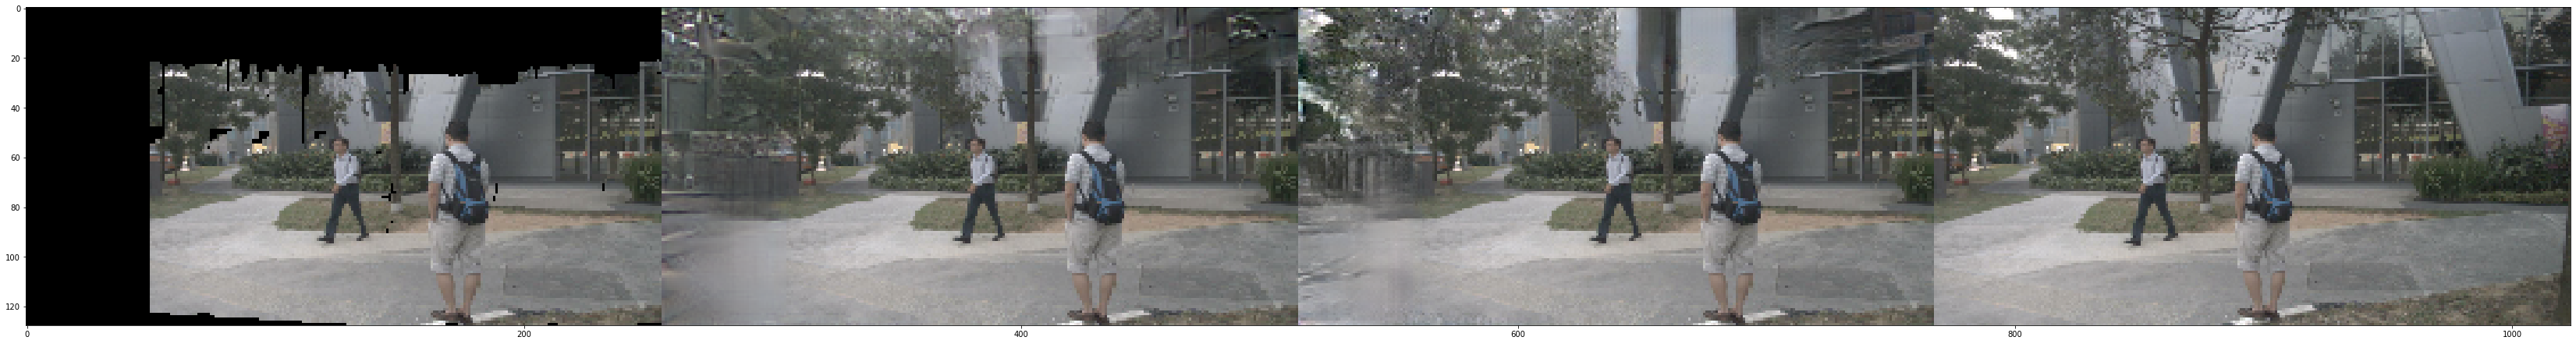

In [6]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


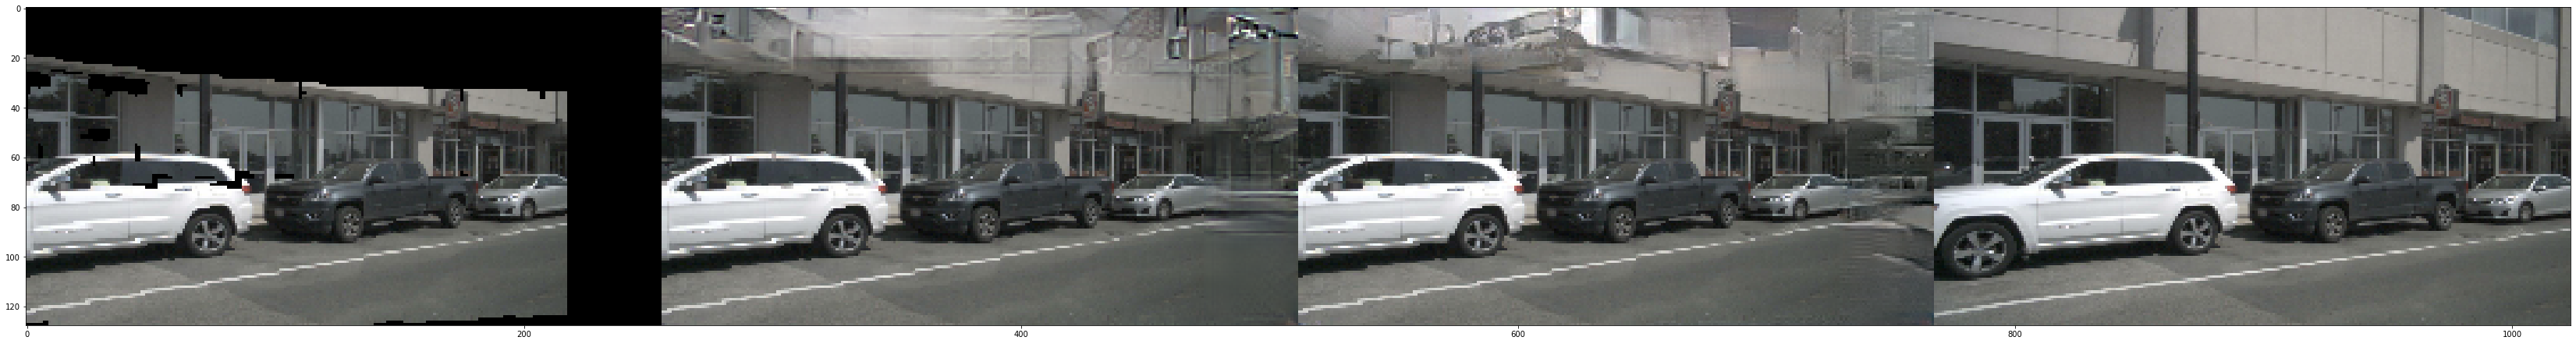

In [7]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


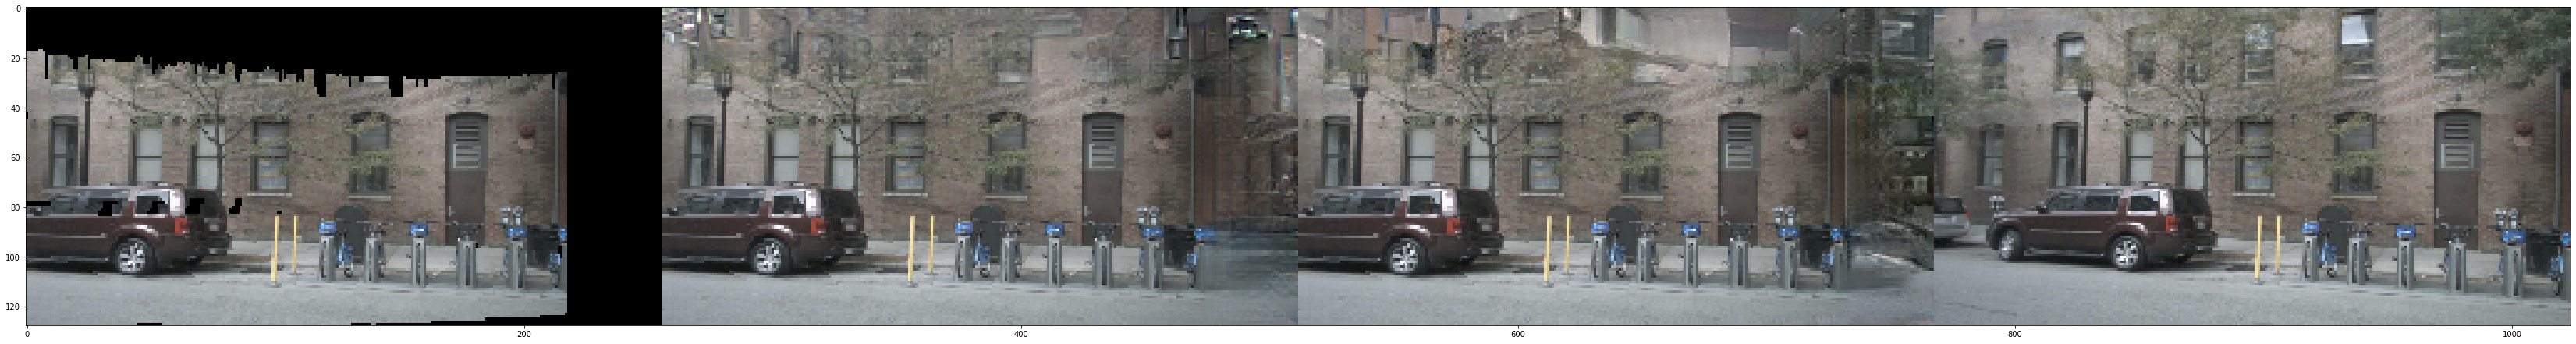

In [8]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


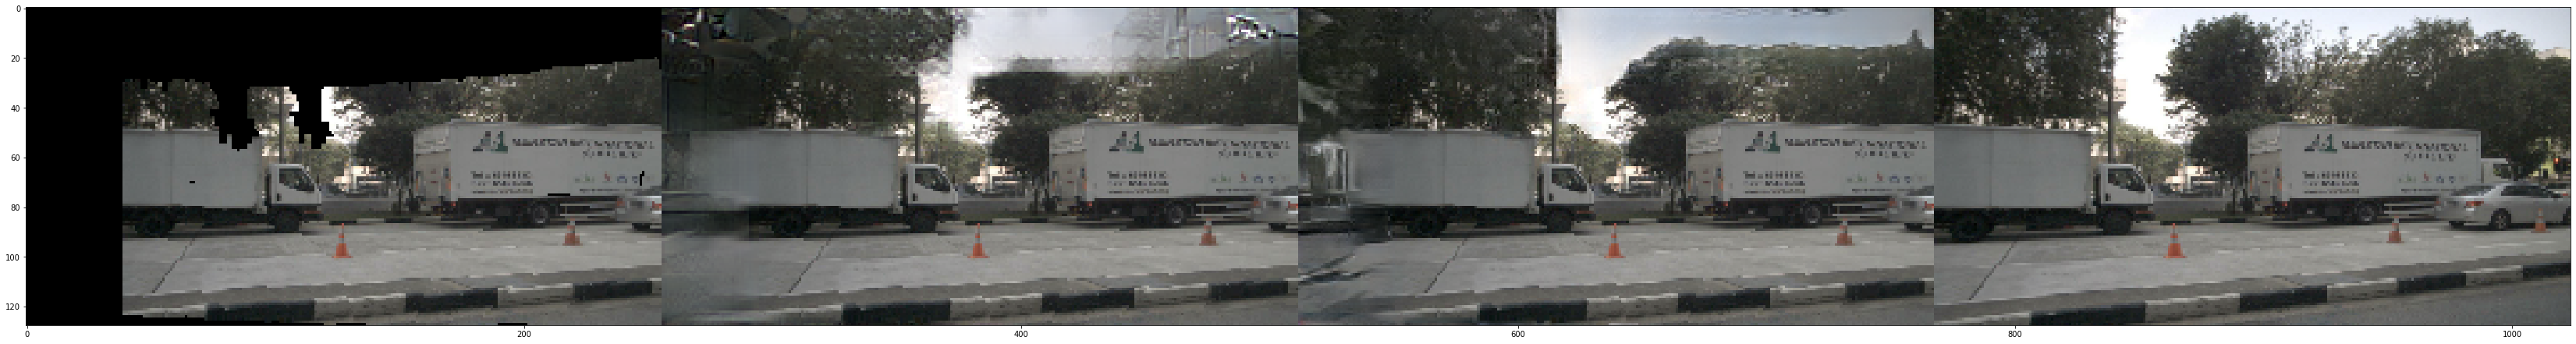

In [9]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


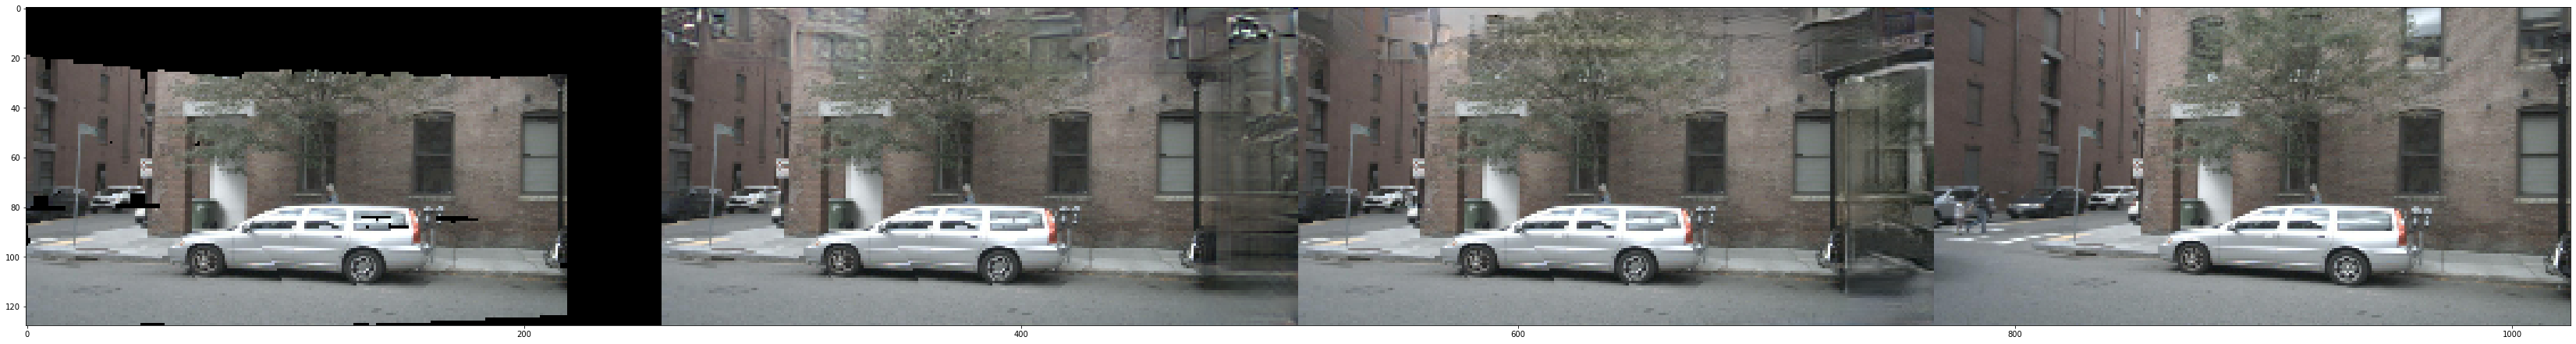

In [10]:
test()

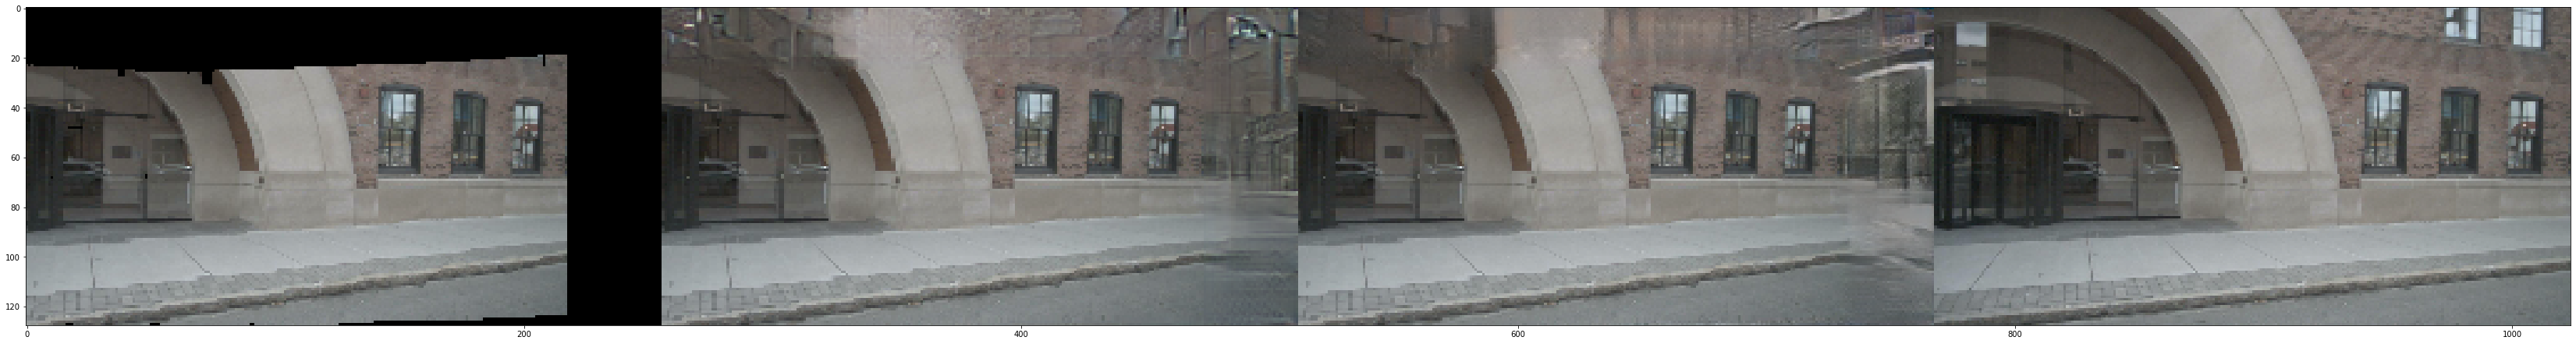

In [11]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


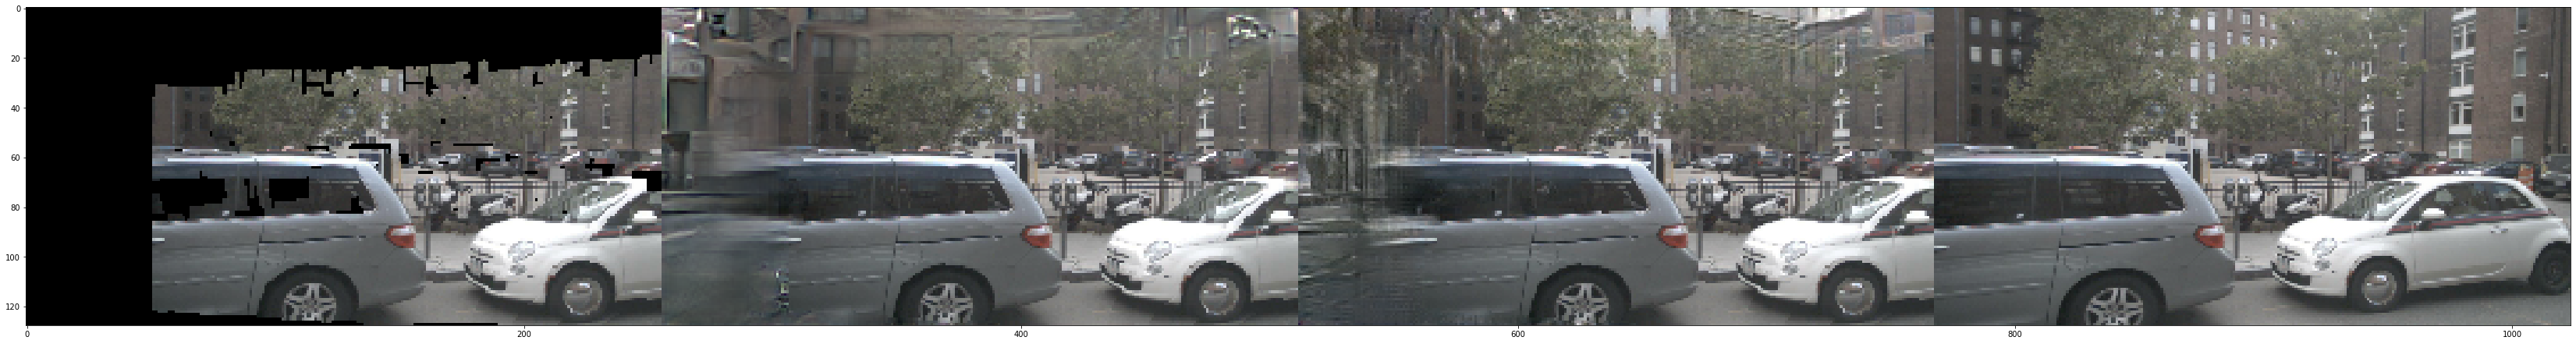

In [12]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


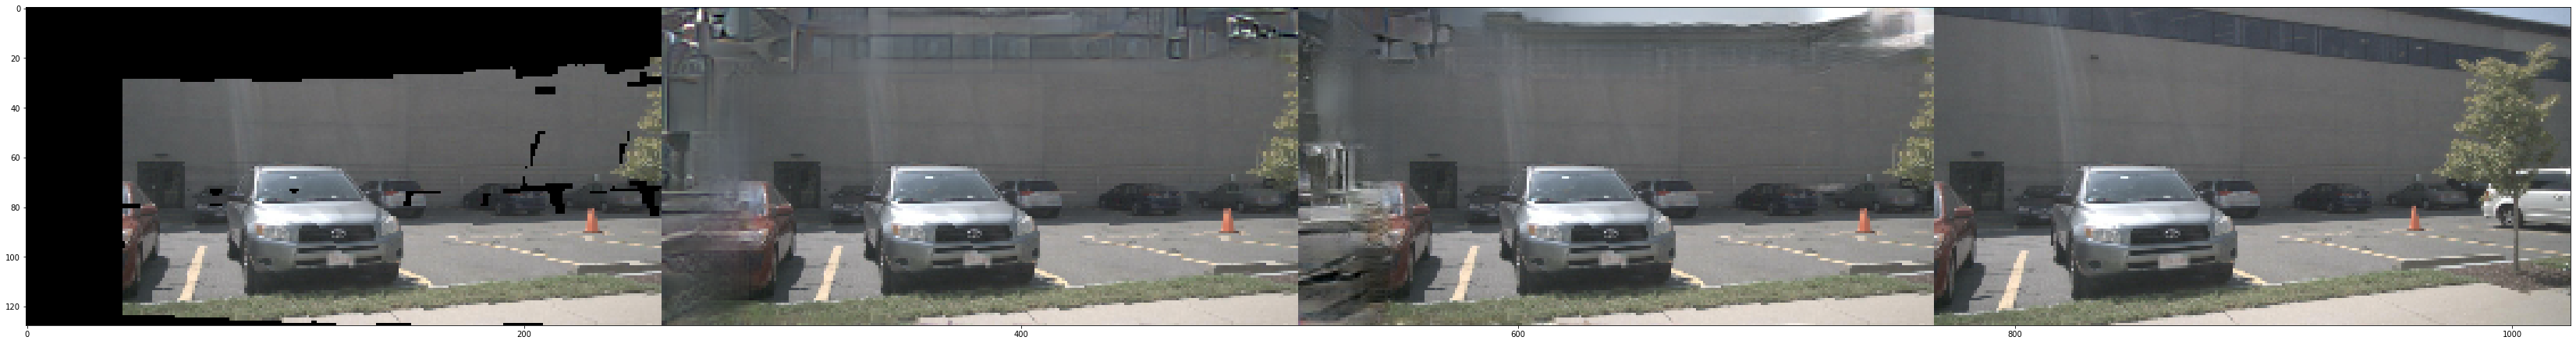

In [13]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


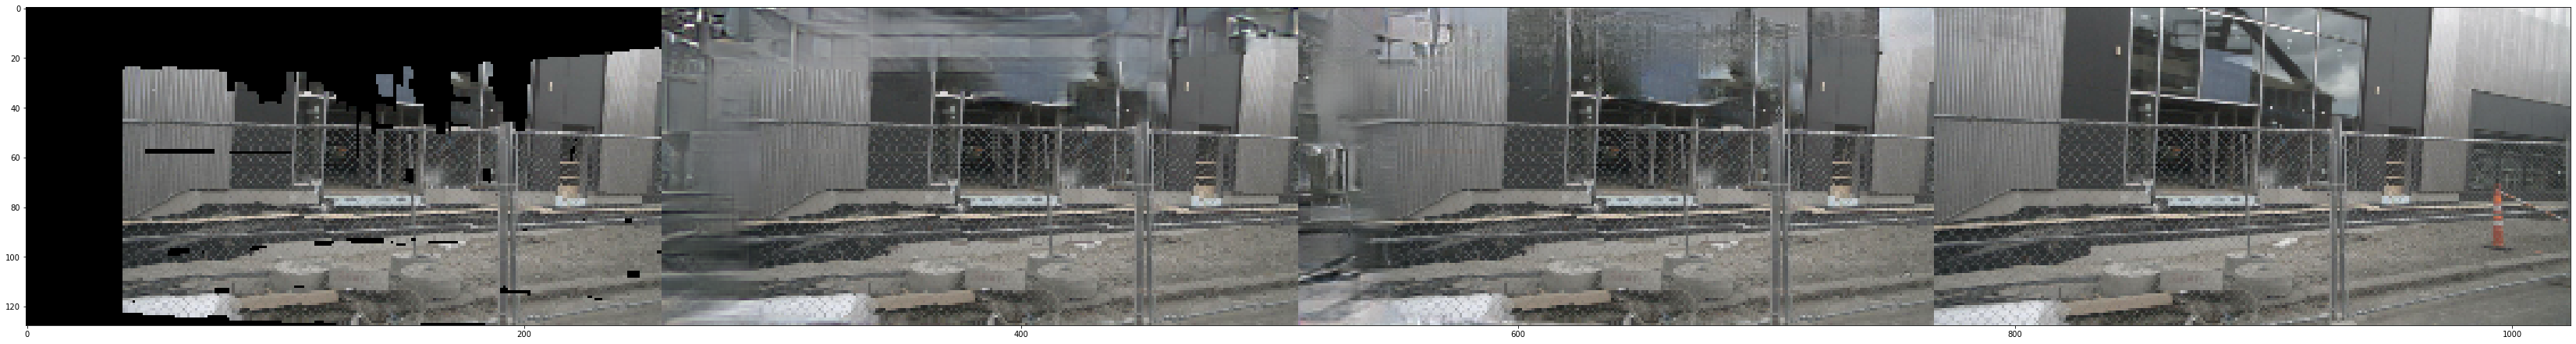

In [14]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


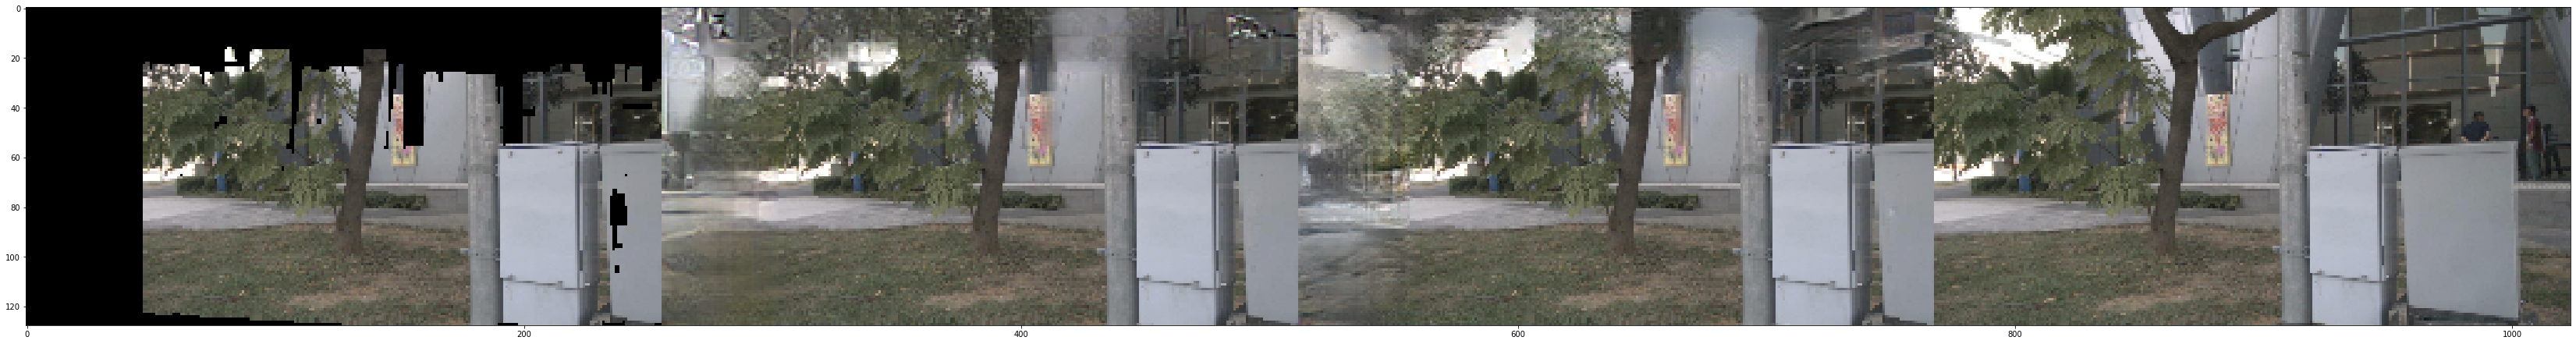

In [15]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


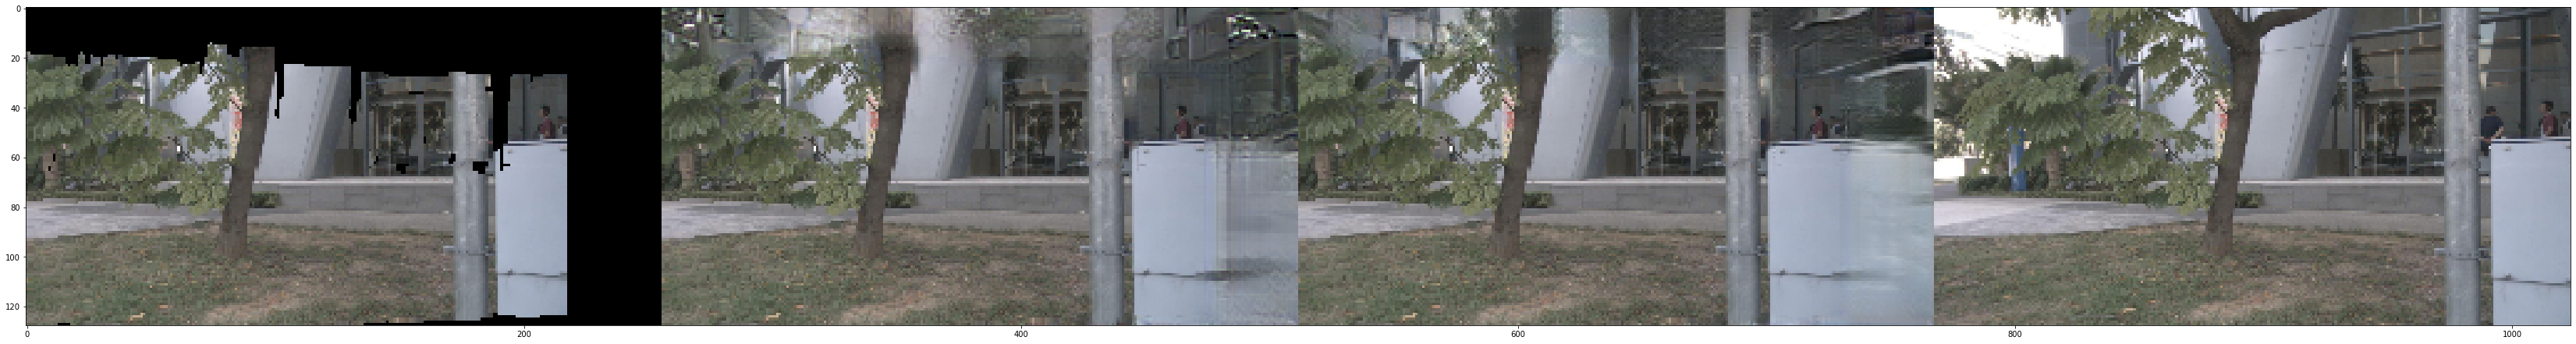

In [16]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


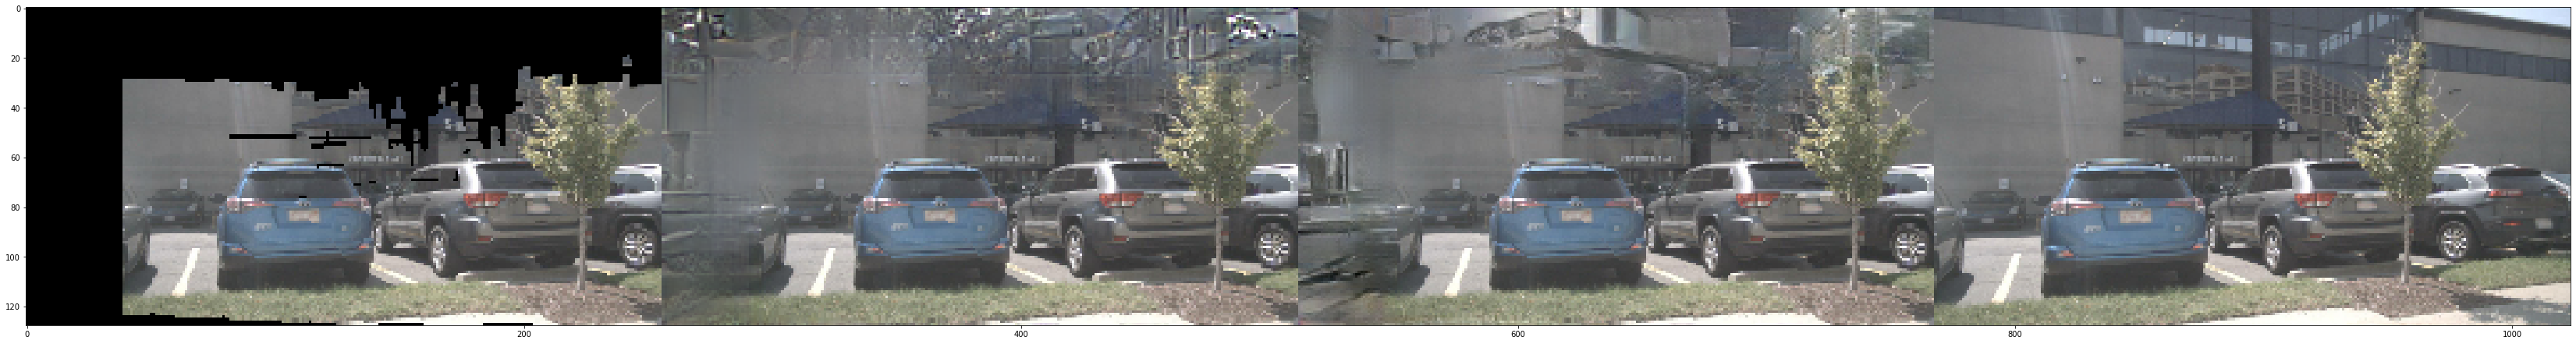

In [17]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


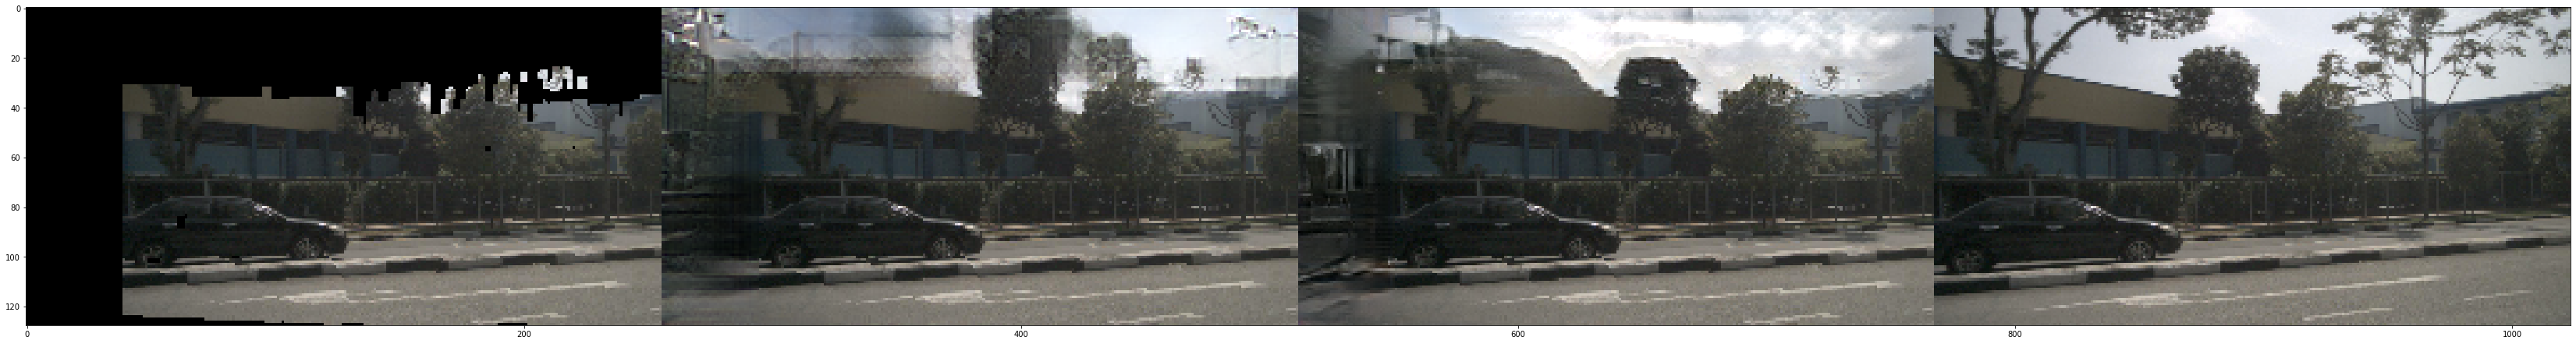

In [18]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


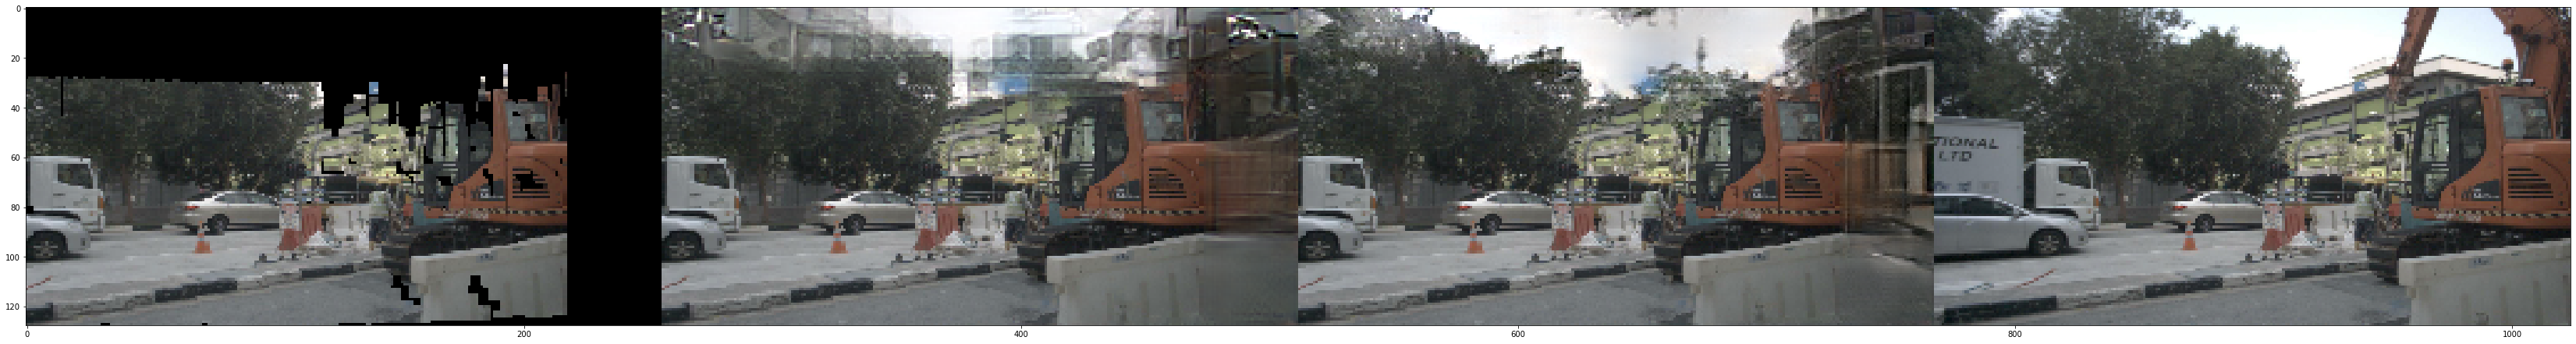

In [19]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


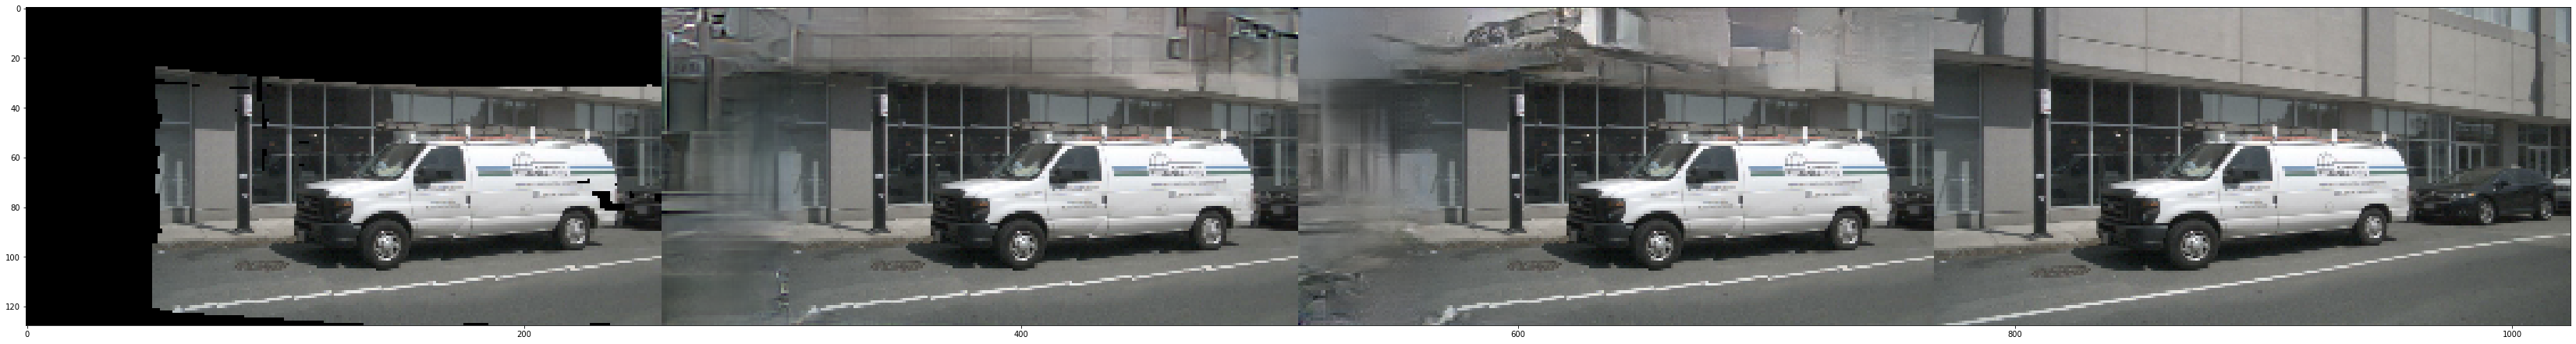

In [20]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


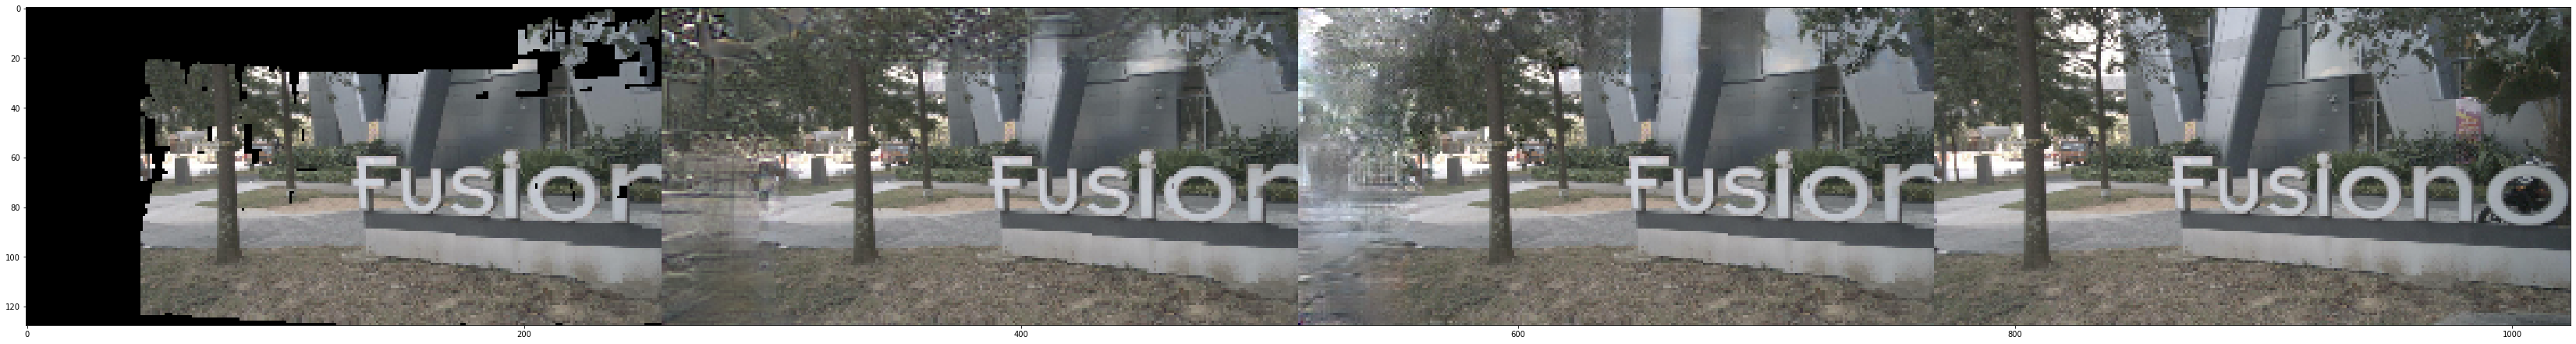

In [21]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


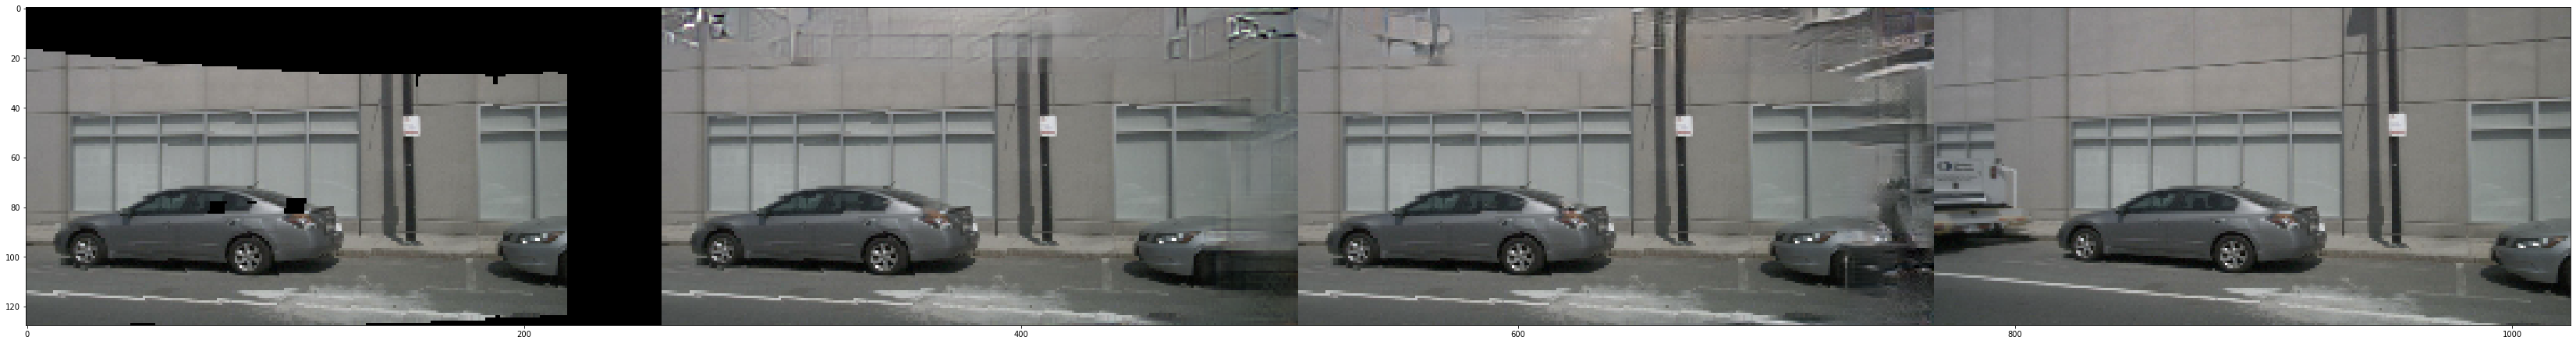

In [22]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


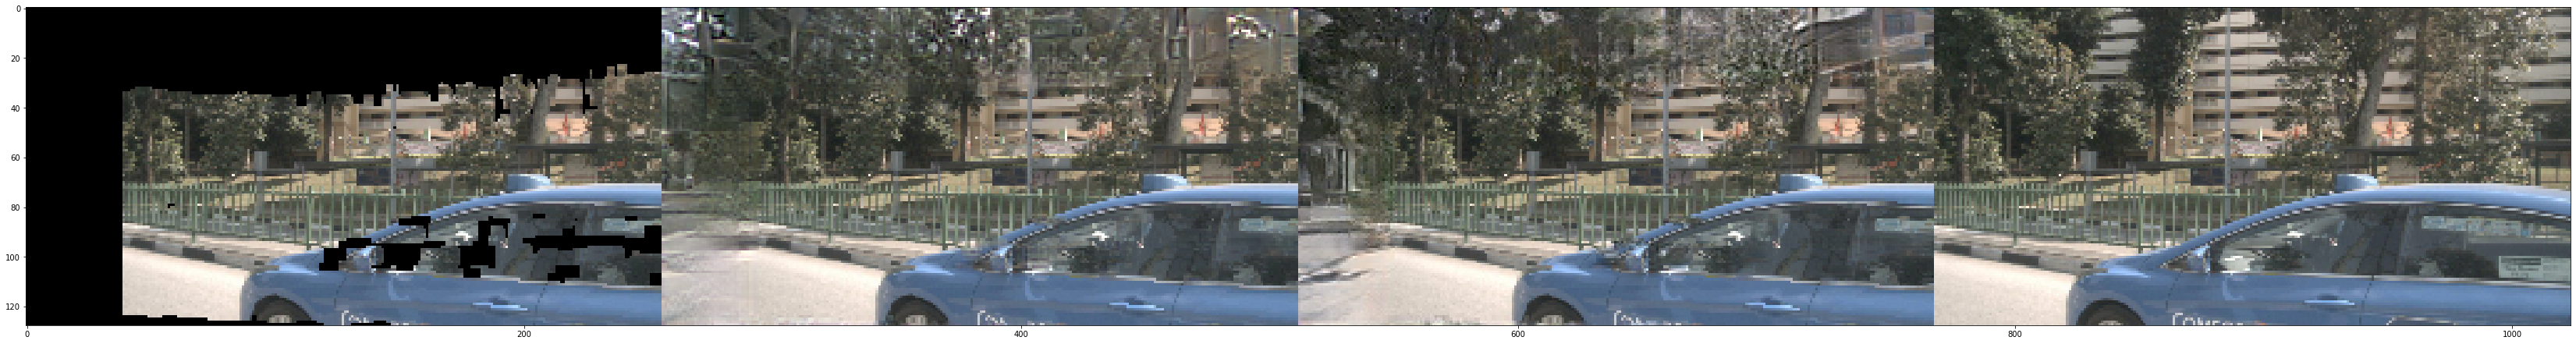

In [23]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


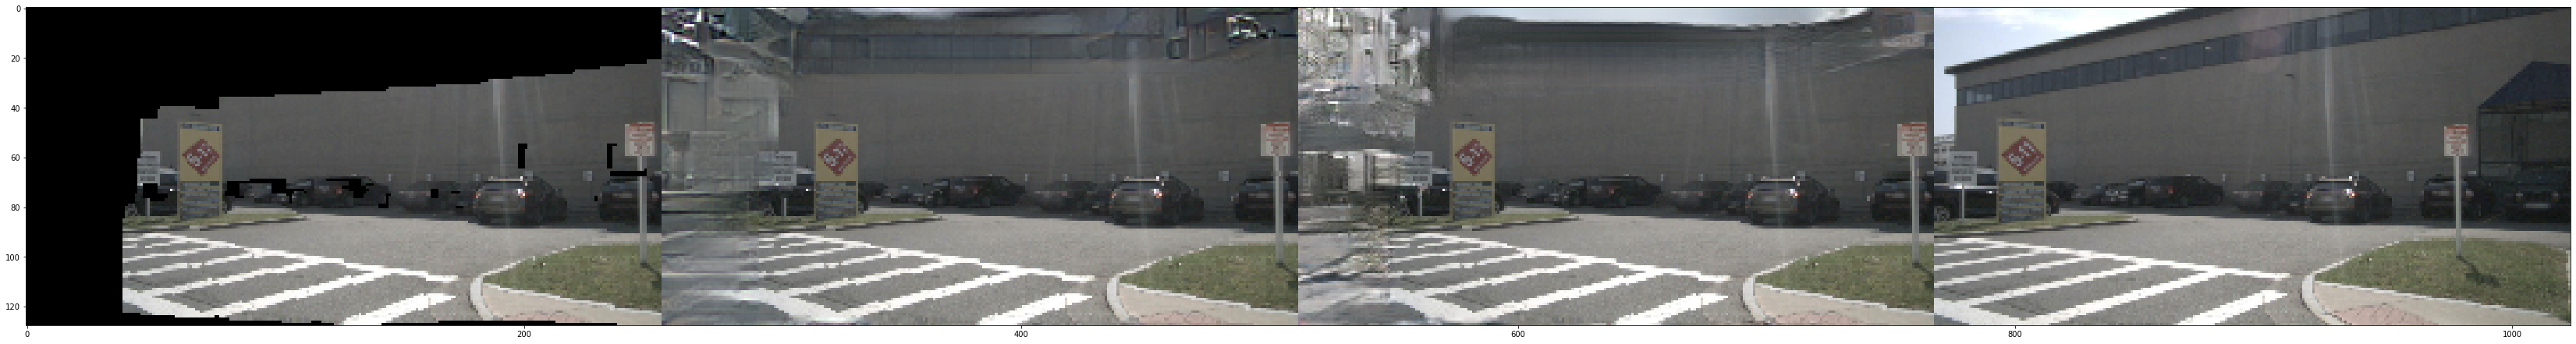

In [24]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


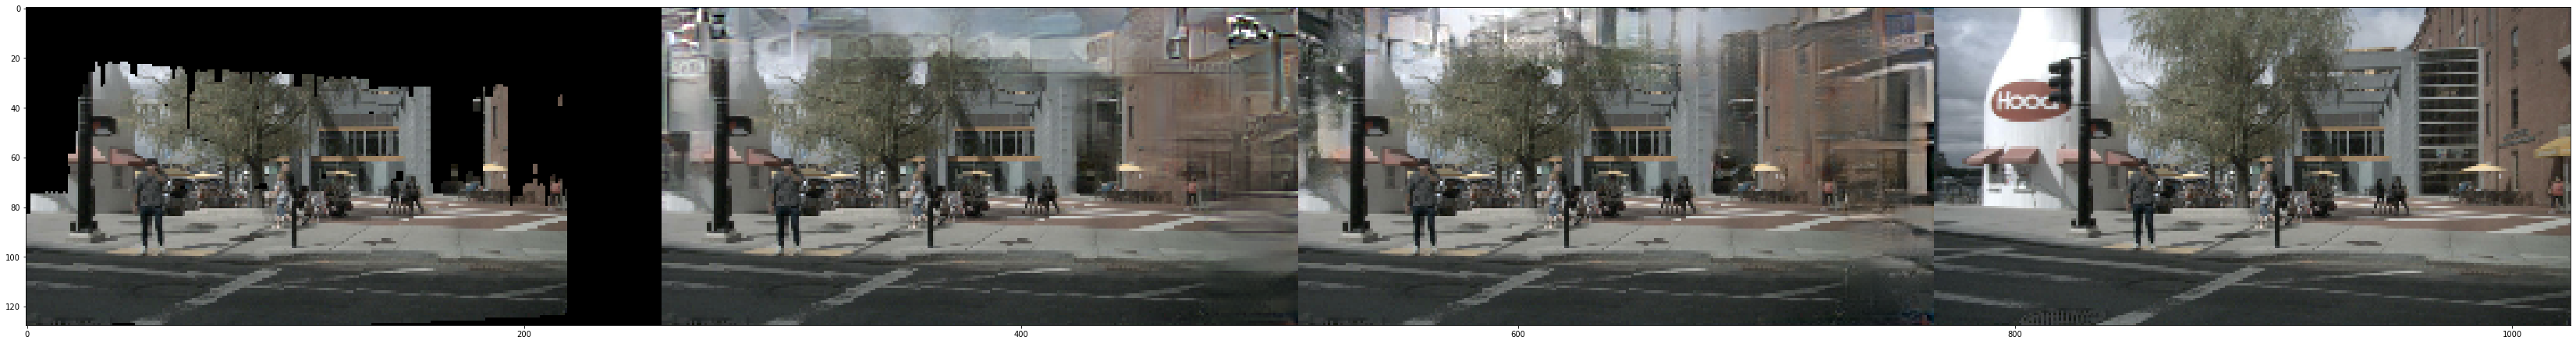

In [25]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


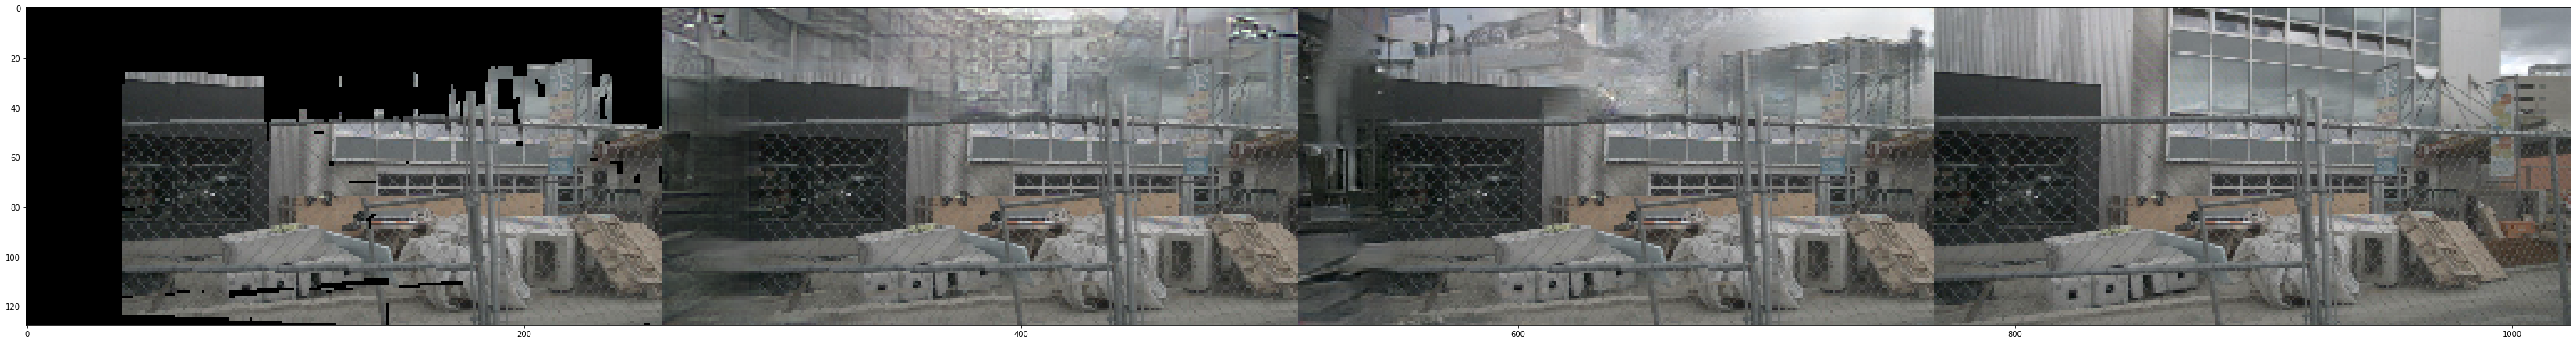

In [26]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


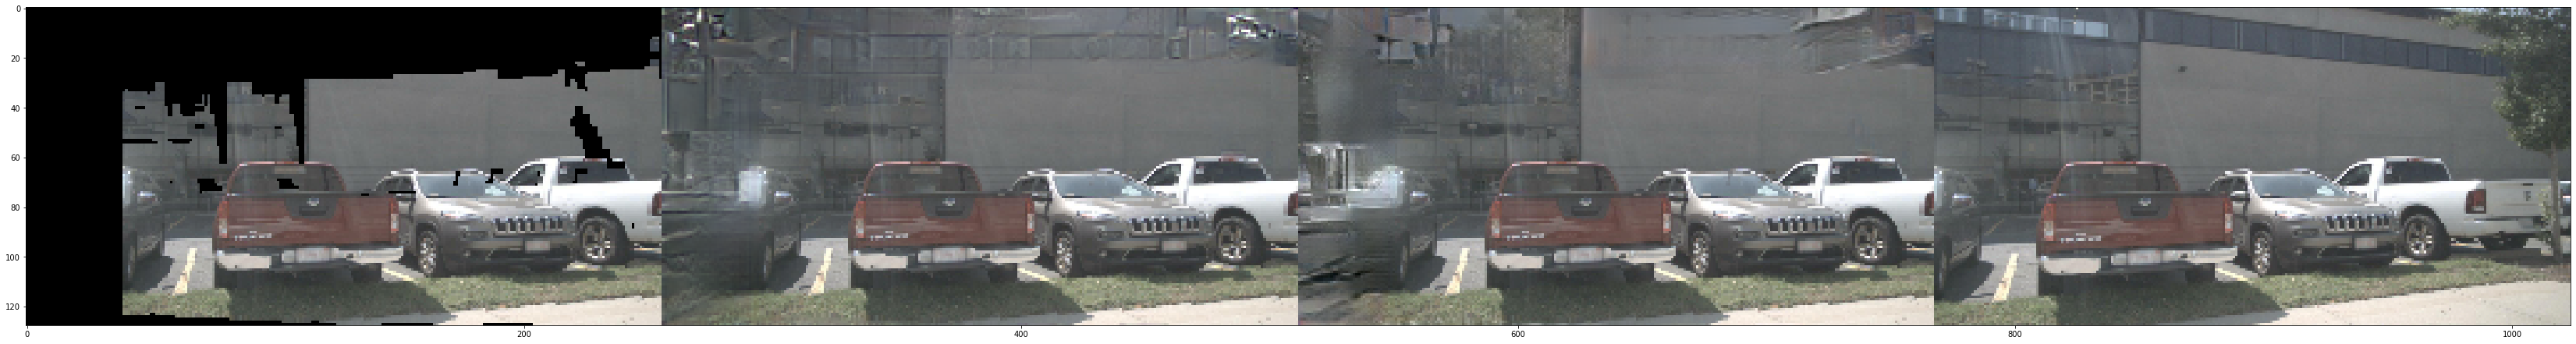

In [27]:
test()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


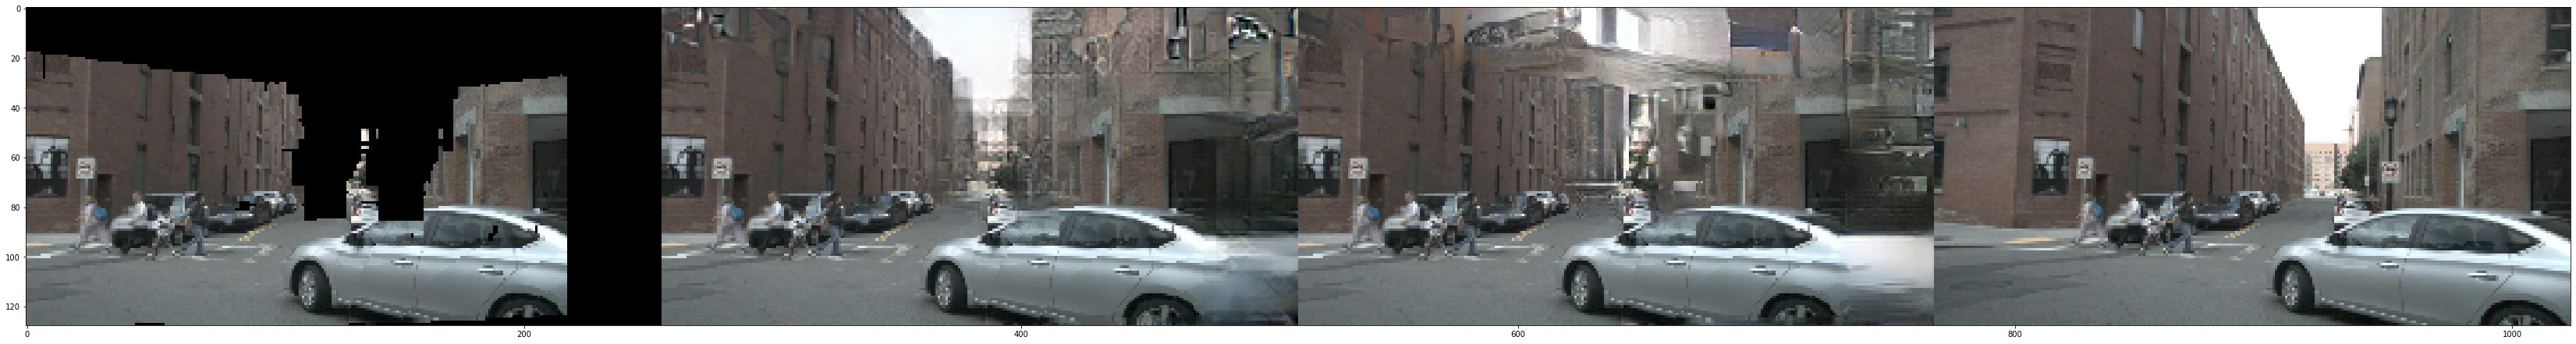

In [28]:
test()

In [ ]:
test()